# Changing Fourier Conventions

The ``powerbox`` package allows for arbitrary Fourier conventions. Since (continuous) Fourier Transforms can be defined using different definitions of the frequency term, and varying normalisations, we allow any consistent combination of these, using the same parameterisation that Mathematica uses, i.e.:

$$ F(k) = \left(\frac{|b|}{(2\pi)^{1-a}}\right)^{n/2} \int f(r) e^{-i b\mathbf{k}\cdot\mathbf{r}} d^n\mathbf{r} $$

for the forward-transform and 

$$ f(r) = \left(\frac{|b|}{(2\pi)^{1+a}}\right)^{n/2} \int F(k) e^{+i b\mathbf{k}\cdot\mathbf{r}} d^n \mathbf{k} $$

for its inverse. Here $n$ is the number of dimensions in the transform, and $a$ and $b$ are free to be any real number. Within ``powerbox``, $b$ is taken to be positive.

The most common choice of parameters is $(a,b) = (0,2\pi)$, which are the parameters that for example ``numpy`` uses. These are the defaults in the ``fft`` and ``ifft`` implemented in ``powerbox.dft``. 

In cosmology (a field which ``powerbox`` was written in the context of), a more usual choice is $(a,b)=(1,1)$, and so these are the defaults within the ``PowerBox`` classes. 

In this notebook we provide some examples on how to deal with these conventions.

Note that in the DFT/FFT, the $x_i$ and $k_i$ are related. Given a set of $N$ values of $x_i$, for which $x_N = (N-1)L/N x_0$ (i.e. each consecutive value is separated by $\Delta x = L/N$), and whose starting point is irrelevant (but see the following section on phases), the FFT returns values of $k_i$:

\begin{equation}
    k_i = \frac{2\pi}{b} \frac{i}{L}, \ \ i \in (-N/2, N/2).
\end{equation}

Similarly, performing an inverse FFT on a function over a set of $N$ $k$-values, whose separation is $\Delta k = L_k/N$, yields the following values of $x'_i$:

\begin{equation}
    x'_i = \frac{2\pi}{b} \frac{i}{L_k} \equiv i\Delta x, \ \ i \in (-N/2, N/2).
\end{equation}

If one performs a round-trip transform (forwards then inverse), the resulting $x'_i$ are equivalent to the input $x_i$, modulo a potential shift. The FFT algorithm itself does not depend on the actual values of the original $x_i$, only their spacing and number, and so without applying any phasing, the $x'_i$ can be assumed to be equivalent to $x_i$. 


## Doing the DFT right.

In many fields, we are concerned primarily with the *continuous* FT, as defined above. However, typically we must evaluate this numerically, and therefore use a DFT or FFT. While the conversion between the two is simple, it is all too easy to forget which factors to normalise by to get back the analogue of the continuous transform. 

That's why in ``powerbox`` we provide some fast fourier transform functions that do all the hard work for you. They not only normalise everything correctly to produce the continuous transform, they also return the associated fourier-dual co-ordinates. And they do all this for arbitrary conventions, as defined above. And they work for any number of dimensions.

Let's take a look at an example, using a simple Gaussian field in 2D:

$$ f(x) = e^{-\pi r^2}, $$

where $r^2 = x^2 + y^2.$

The Fourier transform of this field, using the standard mathematical convention is:

$$ \int e^{-\pi r^2} e^{-2\pi i k\cdot x} d^2x = e^{-\pi k^2}, $$

where $k^2 = k_x^2 + k_y^2$. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from powerbox.dft import fft, ifft, fftshift
from powerbox.powerbox import _magnitude_grid
import powerbox as pbox

In [2]:
pbox.__version__

'0.8.3.dev30+gdf04690e3'

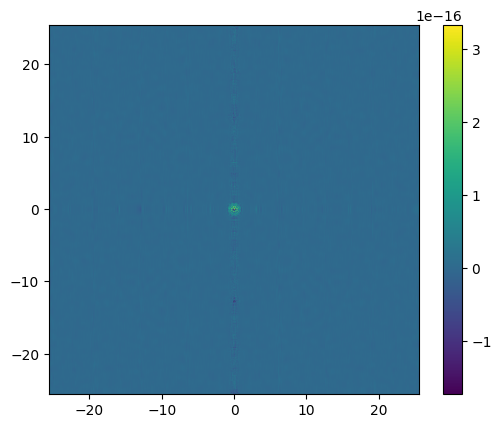

In [3]:
# Parameters of the field
L = 10.0
N = 512
dx = L / N

x = np.arange(-L / 2, L / 2, dx)[:N]  # The 1D field grid
r = _magnitude_grid(x, dim=2)  # The magnitude of the co-ordinates on a 2D grid
field = np.exp(-np.pi * r**2)  # Create the field

# Generate the k-space field, the 1D k-space grid, and the 2D magnitude grid.
k_field, k, rk = fft(
    field,
    L=L,  # Pass the field to transform, and its size
    ret_cubegrid=True,  # Tell it to return the grid of magnitudes.
)

# Plot the field minus the analytic result
plt.imshow(
    k_field.real - np.exp(-np.pi * rk**2),
    extent=(np.min(k), np.max(k), np.min(k), np.max(k)),
)
plt.colorbar();

We can now of course do the inverse transform, to ensure that we return the original:

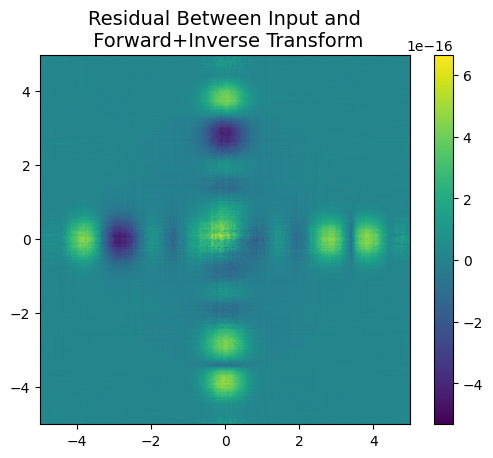

In [4]:
x_field, x_, rx = ifft(
    k_field,
    L=L,  # Note we can pass L=L, or Lk as the extent of the k-space grid.
    ret_cubegrid=True,
)

plt.imshow(np.abs(x_field) - field, extent=(x.min(), x.max(), x.min(), x.max()))
plt.title("Residual Between Input and\n Forward+Inverse Transform", fontsize=14)
plt.colorbar()
plt.show();

We can also check that the xgrid returned is the same as the input xgrid:

In [5]:
x_ - x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2, 512))

### Changing the convention

Suppose we instead required the transform

$$ \int e^{-\pi r^2} e^{-i \nu \cdot x} d^2x = e^{-\nu^2/4\pi}. $$

This is the same transform but with the Fourier-convention $(a,b) = (1,1)$. We would do this like:

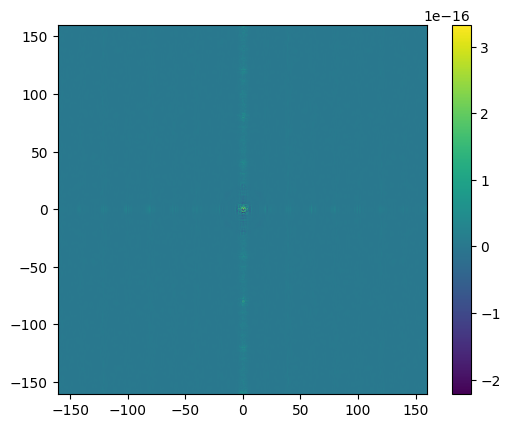

In [6]:
# Generate the k-space field, the 1D k-space grid, and the 2D magnitude grid.
k_field, k, rk = fft(
    field,
    L=L,  # Pass the field to transform, and its size
    ret_cubegrid=True,  # Tell it to return the grid of magnitudes.
    a=1,
    b=1,  # SET THE FOURIER CONVENTION
)

# Plot the field minus the analytic result
plt.imshow(
    np.abs(k_field) - np.exp(-1.0 / (4 * np.pi) * rk**2),
    extent=(np.min(k), np.max(k)) * 2,
)
plt.colorbar();

Again, specifying the inverse transform with these conventions gives back the original:

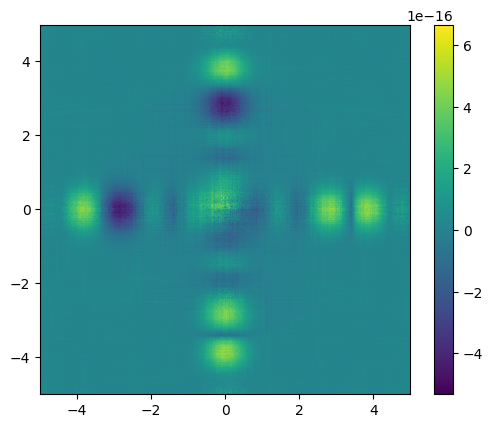

In [7]:
x_field, x_, rx = ifft(
    k_field,
    L=L,  # Note we can pass L=L, or Lk as the extent of the k-space grid.
    ret_cubegrid=True,
    a=1,
    b=1,
)

plt.imshow(np.abs(x_field) - field, extent=(x.min(), x.max(), x.min(), x.max()))
plt.colorbar()
plt.show();

### Mixing up conventions

It may be that sometimes the forward and inverse transforms in a certain problem will have different conventions. Say the forward transform has parameters $(a,b)$, and the inverse has parameters $(a',b')$. Then first taking the forward transform, and *then* inverting it (in $n$-dimensions) would yield:

$$ \left( \frac{b'}{b(2\pi)^{a'-a}}\right)^{n/2} f\left(\frac{b'r}{b}\right), $$

and doing it the other way would yield:

$$ \left( \frac{b}{b'(2\pi)^{a'-a}}\right)^{n/2} F\left(\frac{bk}{b'}\right). $$

The ``fft`` and ``ifft`` functions handle these easily. For example, if $(a,b) = (0,2\pi)$ and $(a',b') = (0,1)$, then the 2D forward-then-inverse transform should be

$$ f(r/(2\pi))/ 2\pi, $$

and the inverse-then-forward should be

$$ 2\pi F(2\pi k). $$


/home/sgm/work/tools/powerbox/src/powerbox/tools.py:256: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


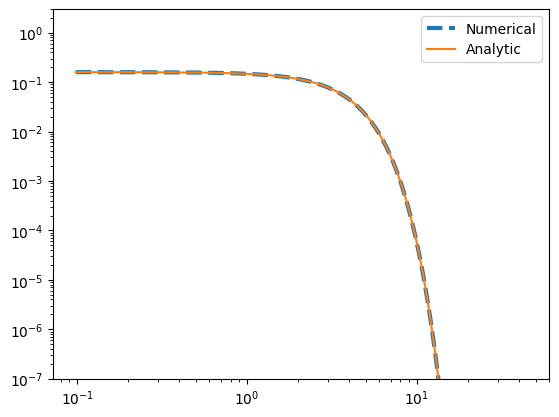

In [9]:
# Do the forward transform
k_field, k, rk = fft(field, L=L, a=0, b=2 * np.pi, ret_cubegrid=True)

# Do the inverse transform, ensuring the boxsize is correct
mod_field, modx, modr = ifft(k_field, Lk=-2 * np.min(k), a=0, b=1, ret_cubegrid=True)

mod_field, bins, *_ = pbox.angular_average(mod_field.real, modr, 300)

plt.plot(bins, mod_field, label="Numerical", lw=3, ls="--")
plt.plot(
    bins, np.exp(-np.pi * (bins / (2 * np.pi)) ** 2) / (2 * np.pi), label="Analytic"
)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-7, 3)
plt.show()

### FFT Phases

One thing that can sometimes be frustrating about the FFT/IFFT is that it assumes that the input function begins at $x=0$ (or $k=0$). While the magnitude of the output is insensitive to this choice, the phase of the output is. This can result in the FFT of a Gaussian, for example, exhibiting highly oscillatory behaviour in its real and imaginary components. 

Since ``powerbox.dft`` is all about being able to simply compute what you would "expect" for a continuous function, we give a simple option for specifying what your actual $x$-co-ordinates are. In fact, by default, ``powerbox`` assumes that the _centre_ of the array is the zero co-ordinate, which is more likely in usual analytic setups. 

To specify a different co-ordinate system, just specify ``left_edge`` in ``fft`` or ``ifft``. For instance, ``left_edge=0`` will perform the usual ``fft``. The default is ``left_edge = -L/2``. You can specify a list of values, one for each transformed axis. The value can be any real value -- we don't merely cycle the input before transforming, we rather apply the Fourier Shift theorem. However, do note that applying a value other than $-L/2$ will mean that a round-trip transform cannot be an identity operation.

Remember that both ``fft`` and ``ifft`` assume that the central value is zero by default, and they both have outputs which conform to this standard, so that ``x == ifft(fft(x))``. The standard (``numpy``) behaviour can be obtained by using ``x == fftshift(ifft(fft(x, left_edge=0)))``. 


In [10]:
print(np.allclose(field, ifft(fft(field, L=L)[0], L=L)[0]))
print(np.allclose(field, fftshift(ifft(fft(field, L=L, left_edge=0)[0], L=L)[0])))

True
True


In [11]:
print(np.allclose(field, fft(ifft(field, L=L)[0], L=L)[0]))
print(np.allclose(field, fftshift(fft(ifft(field, L=L, left_edge=0)[0], L=L)[0])))

True
True


## Using Different Conventions in Powerbox

These fourier-transform wrappers are used inside powerbox to do the heavy lifting. That means that one can pass a power spectrum which has been defined with arbitrary conventions, and receive a fully consistent box back.

Let's say, for example, that the fourier convention in your field was to use $(a,b)=(0,1)$, so that the power spectrum of a 2D field, $\delta_x$ was given by

$$P(k) =  \frac{1}{2\pi} \int \delta_x e^{-ikx} d^2x. $$

We now wish to create a realisation with a power spectrum following these conventions. Let's say the power spectrum is $P(k) = 0.1k^{-3}$.

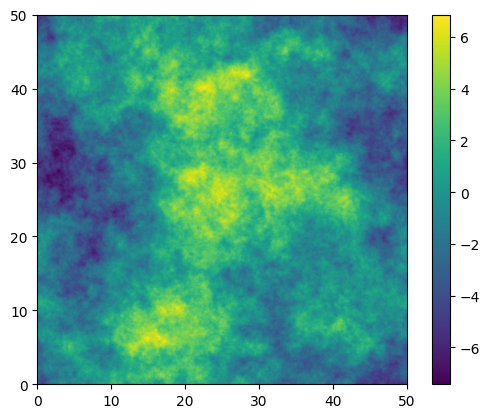

In [12]:
pb = pbox.PowerBox(
    N=512,
    dim=2,
    pk=lambda k: 0.1 * k**-3.0,
    a=0,
    b=1,  # Set the Fourier convention
    boxlength=50.0,  # Has units of inverse k
)

plt.imshow(pb.delta_x(), extent=(0, 50, 0, 50))
plt.colorbar()
plt.show()

When we check the power spectrum, we also have to remember to set the Fourier convention accordingly:

/home/sgm/work/tools/powerbox/src/powerbox/tools.py:256: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


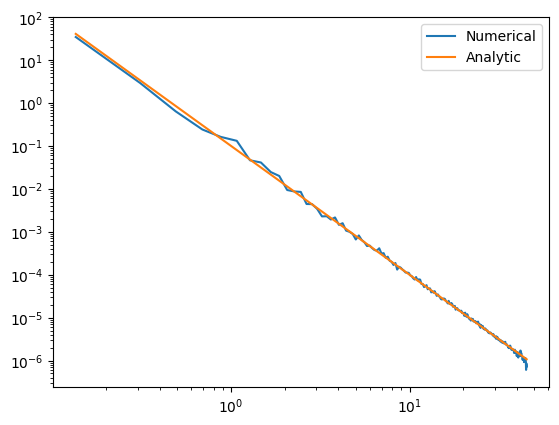

In [14]:
power, kbins, *_ = pbox.get_power(pb.delta_x(), pb.boxlength, a=0, b=1)

plt.plot(kbins, power, label="Numerical")
plt.plot(kbins, 0.1 * kbins**-3.0, label="Analytic")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

## Using non-cubic boxes in the DFT

So far, all the boxes we've FT'd have been cubic. However, the DFT can be performed on any box, and the ``fft`` and ``ifft`` functions can handle this.

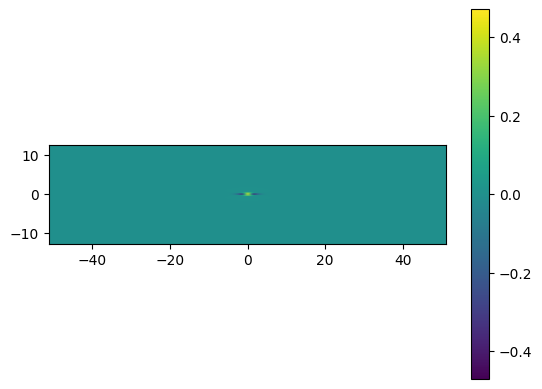

In [15]:
# Parameters of the field
L = (10.0, 20.0)
N = (512, 1024)
dx = L[0] / N[0]

x = [
    np.arange(-length / 2, length / 2, dx)[:num] for length, num in zip(L, N)
]  # The 1D field grid
r = _magnitude_grid(x)  # The magnitude of the co-ordinates on a 2D grid
field = np.exp(-np.pi * r.T**2)  # Create the field

# Generate the k-space field, the 1D k-space grid, and the 2D magnitude grid.
k_field, k, rk = fft(
    field,  # The field to transform
    L=L,  # Now L is a tuple of lengths on each axis
    ret_cubegrid=True,  # Tell it to return the grid of magnitudes.
)

# Plot the field minus the analytic result
plt.imshow(
    k_field.real - np.exp(-np.pi * rk**2),
    extent=(k[0].min(), k[0].max(), k[1].min(), k[1].max()),
)
plt.colorbar();

Note that the output is square in its extents. This is because the resolution of each axis is the same (double the size, double the pixels). However, the *shape* of the output field is different:

In [ ]:
k_field.shape

(512, 1024)